In [ ]:
# default_exp inference.inference

# Inference

> Provides faster inference scripts

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from fastinference.soft_dependencies import SoftDependencies
if not SoftDependencies.check()['light']:
    raise ImportError("The fastai module is not installed.")

ModuleNotFoundError: No module named 'fastinference.soft_dependencies'

In [ ]:
#export
from fastai.learner import _ConstantFunc
from fastai.vision.all import *
from fastai.tabular.all import *

In [ ]:
#export
@typedispatch
def _fully_decode(dl:TfmdDL, inps, outs):
    "Attempt to fully decode the `inp"
    inps = dl.decode(inps)
    dec = []
    for d in inps:
        for e in d:
            e = retain_type(e, typ=type(d))
            dec.append(e)
    outs.insert(len(outs), dec)
    return outs

@typedispatch
def _fully_decode(dl:TabDataLoader, inps, outs):
    "Attempt to fully decode the `inp"
    for i in range(dl.n_inp):
        inps[i] = torch.cat(inps[i], dim=0)
    dec = dl.decode(inps)
    outs.insert(len(outs), dec)
    return outs

def _decode_loss(vocab, dec_out, outs):
    i2c, dec2c = {}, []
    try:
        for i, vocab in enumerate(list(vocab)):
                i2c[i] = vocab
        for i, item in enumerate(dec_out):
            dec2c.append(i2c[int(item)])
        dec_out = dec2c
        outs.insert(0, dec_out)
    except:
        outs.insert(0, dec_out)
    return outs

In [ ]:
#export
@delegates(GatherPredsCallback.__init__)
@patch
def get_preds(self:Learner, ds_idx=1, dl=None, with_input=False, with_decoded=False, with_loss=False, raw=False, act=None,
                inner=False, reorder=True, cbs=None, **kwargs):
    if dl is None: dl = self.dls[ds_idx].new(shuffled=False, drop_last=False)
    if reorder and hasattr(dl, 'get_idxs'):
        idxs = dl.get_idxs()
        dl = dl.new(get_idxs = _ConstantFunc(idxs))
    cb = GatherPredsCallback(with_input=with_input, with_loss=with_loss, **kwargs)
    ctx_mgrs = self.validation_context(cbs=L(cbs)+[cb], inner=inner)
    if with_loss: ctx_mgrs.append(self.loss_not_reduced())
    with ContextManagers(ctx_mgrs):
        self._do_epoch_validate(dl=dl)
        if act is None: act = getattr(self.loss_func, 'activation', noop)
        res = cb.all_tensors()
        pred_i = 1 if with_input else 0
        if res[pred_i] is not None:
            res[pred_i] = act(res[pred_i]) if not raw else res[pred_i]
            if with_decoded: 
                res.insert(pred_i+2, getattr(self.loss_func, 'decodes', noop)(res[pred_i]))
        if reorder and hasattr(dl, 'get_idxs'): res = nested_reorder(res, tensor(idxs).argsort())
        if with_decoded:
            if hasattr(self.dls, 'categorize'): res[pred_i+1] = apply(getattr(self.dls, 'categorize', noop).decode, [*res[pred_i+2]])
            if hasattr(self.dls, 'multi_categorize'): res[pred_i+1] = apply(getattr(self.dls, 'multi_categorize', noop).decode, [*res[pred_i+2]])
        return tuple(res)
    self._end_cleanup()

In [ ]:
show_doc(Learner.get_preds)

<h4 id="Learner.get_preds" class="doc_header"><code>Learner.get_preds</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.get_preds</code>(**`ds_idx`**=*`1`*, **`dl`**=*`None`*, **`with_input`**=*`False`*, **`with_decoded`**=*`False`*, **`with_loss`**=*`False`*, **`raw`**=*`False`*, **`act`**=*`None`*, **`inner`**=*`False`*, **`reorder`**=*`True`*, **`cbs`**=*`None`*, **\*\*`kwargs`**)



This function is *almost* the exact same as `fastai`'s. The big difference is we can return our raw outputs or our class names.

> Note: to speed up inference, multi-processing *will* slow you down. In production use `num_workers=0` unless you have a large amount of vision data being passed at one time

In [ ]:
#export
@patch
def predict(x:Learner, item, with_input=False, rm_type_tfms=None):
        dl = x.dls.test_dl([item], rm_type_tfms=rm_type_tfms, num_workers=0)
        res = x.get_preds(dl=dl, with_input=with_input, with_decoded=True)
        return res

In [ ]:
#export
@patch
def predict(x:TabularLearner, row, with_input=False, rm_type_tfms=None):
        dl = x.dls.test_dl(row.to_frame().T)
        dl.dataset.conts = dl.dataset.conts.astype(np.float32)
        res = x.get_preds(dl=dl, with_decoded=True, with_input=with_input)
        return res

## Examples

Below is examples with `Vision`, `Tabular`, and `Text`:

### Vision

We'll use the `PETs` dataset:

In [ ]:
path = untar_data(URLs.PETS)
fnames = get_image_files(path/'images')
pat = r'(.+)_\d+.jpg$'
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
bs=64

In [ ]:
dls = ImageDataLoaders.from_name_re(path, fnames, pat, batch_tfms=batch_tfms, 
                                   item_tfms=item_tfms, bs=bs)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)

In [ ]:
o = learn.predict(fnames[0], with_input=False)

In [ ]:
o

(tensor([[1.4304e-08, 2.5611e-05, 1.6173e-05, 5.7103e-02, 5.6983e-06, 4.3949e-03,
          1.1635e-09, 1.9718e-04, 3.6130e-07, 5.3789e-08, 2.8925e-06, 9.1773e-01,
          6.7786e-05, 1.2413e-05, 2.5257e-06, 8.6121e-05, 9.6604e-06, 1.1303e-02,
          7.5059e-03, 5.4293e-08, 2.4380e-09, 8.4304e-05, 3.3945e-05, 3.7062e-08,
          7.4087e-08, 8.1876e-04, 1.1356e-05, 6.7219e-06, 1.9465e-06, 4.0787e-07,
          2.3148e-07, 5.4692e-04, 3.0157e-08, 2.4145e-06, 5.2035e-08, 1.5288e-05,
          9.8272e-06]]),
 ['Sphynx'],
 tensor([11]))

In [ ]:
imgs, probs, classes, clas_idx = learn.get_preds(dl=learn.dls.test_dl(fnames[:3]), with_input=True, with_decoded=True)

The first index will contain our **raw** transformed images:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


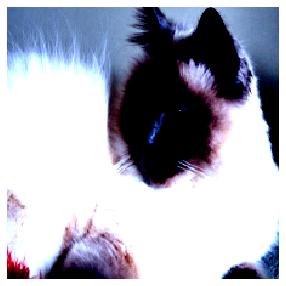

In [ ]:
TensorImage(imgs[0]).show()

Second the probabilities

In [ ]:
probs[0]

tensor([1.4304e-08, 2.5611e-05, 1.6173e-05, 5.7103e-02, 5.6983e-06, 4.3949e-03,
        1.1635e-09, 1.9718e-04, 3.6130e-07, 5.3789e-08, 2.8925e-06, 9.1773e-01,
        6.7786e-05, 1.2413e-05, 2.5257e-06, 8.6121e-05, 9.6605e-06, 1.1303e-02,
        7.5060e-03, 5.4293e-08, 2.4380e-09, 8.4304e-05, 3.3945e-05, 3.7062e-08,
        7.4088e-08, 8.1876e-04, 1.1356e-05, 6.7219e-06, 1.9465e-06, 4.0787e-07,
        2.3148e-07, 5.4693e-04, 3.0157e-08, 2.4144e-06, 5.2035e-08, 1.5288e-05,
        9.8272e-06])

And third our class names:

In [ ]:
classes[0]

'Sphynx'

### Tabular

We'll use the `ADULT_SAMPLE` dataset:

In [ ]:
from fastai.tabular.all import *

In [ ]:
path = untar_data(URLs.ADULT_SAMPLE)

In [ ]:
df = pd.read_csv(path/'adult.csv')
splits = RandomSplitter()(range_of(df))
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]
y_names = 'salary'

In [ ]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                   y_names=y_names, splits=splits)

In [ ]:
dls = to.dataloaders()

In [ ]:
learn = tabular_learner(dls, layers=[200,100])

In [ ]:
inp, probs, name, cat_idx = learn.predict(df.iloc[0], with_input=True)

In [ ]:
inp

(tensor([[5, 8, 3, 0, 6, 5, 1]]), tensor([[ 0.7608, -0.8399,  0.7488]]))

For tabular, our input is a `TabularPandas` row. We can decode that row utilizing the `DataLoaders` `decode` function to generate it, and show it:

In [ ]:
learn.dls.decode(inp).show()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num
0,Private,Assoc-acdm,Married-civ-spouse,#na#,Wife,White,False,49.0,101319.999368,12.0
